## Creating and executing MDF models
    
    The aim of creating this models is to know how to:

1. **Create and execute MDF models with graphs, nodes, parameters and Edges.**
2. **Create and execute MDF models that has a stateful parameter.**
3. **Create and execute MDF models that has a condition controlling the flow node operations.**

## 1. Create a Model with three nodes containing unique mathematics expression <br>
 Create an MDF that has a graph with three nodes, where each node has mathematical expressions that can be evaluated

In [1]:
# Import all the required libraries
from modeci_mdf.mdf import *
import os
import sys
from pathlib import Path
from modeci_mdf.utils import load_mdf
from modeci_mdf.interfaces.pytorch.exporter import mdf_to_pytorch
from modeci_mdf.execution_engine import EvaluableGraph

In [2]:
# Create a model 
mod = Model(id="3-connected-nodes")
# Defining graph for our model
mod_graph = Graph(id="state_example")
# Adding graph in our mod.graphs
mod.graphs.append(mod_graph)

a_node = Node(id="A")

a_node.parameters.append(Parameter(id="level", value=1.0))
a_node.output_ports.append(OutputPort(id="output", value = "level"))

mod_graph.nodes.append(a_node)

#https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter
#Add a stateless parameter - this is a parameter which will evaluate to the same value every execution of the node (for the same external inputs)
b_node = Node(id="B")
b_node.input_ports.append(InputPort(id="input"))
mod_graph.nodes.append(b_node)
p1 = Parameter(
    id="2nd-node",
    value="1/(1+(input))",
)

b_node.parameters.append(p1)

b_node.output_ports.append(OutputPort(id="output", value="2nd-node"))


#Add a stateful parameter - this is a parameter whose value is influenced by a previous value of a parameter, possibly itself

c_node = Node(id="C")
c_node.input_ports.append(InputPort(id="input"))
mod_graph.nodes.append(c_node)
c_node.parameters.append(Parameter(id="3rd-node", value="100*input"))


c_node.output_ports.append(OutputPort(id="output", value="3rd-node"))



# Print the current structure
print(mod_graph.to_yaml())



state_example:
    nodes:
        A:
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level
        B:
            input_ports:
                input: {}
            parameters:
                2nd-node:
                    value: 1/(1+(input))
            output_ports:
                output:
                    value: 2nd-node
        C:
            input_ports:
                input: {}
            parameters:
                3rd-node:
                    value: 100*input
            output_ports:
                output:
                    value: 3rd-node



In [3]:
from modeci_mdf.utils import simple_connect

e1 = simple_connect(a_node, b_node, mod_graph)
e2 = simple_connect(b_node, c_node, mod_graph)


# Print the current structure
print(mod_graph.to_yaml())


state_example:
    nodes:
        A:
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level
        B:
            input_ports:
                input: {}
            parameters:
                2nd-node:
                    value: 1/(1+(input))
            output_ports:
                output:
                    value: 2nd-node
        C:
            input_ports:
                input: {}
            parameters:
                3rd-node:
                    value: 100*input
            output_ports:
                output:
                    value: 3rd-node
    edges:
        edge_A_B:
            sender: A
            receiver: B
            sender_port: output
            receiver_port: input
        edge_B_C:
            sender: B
            receiver: C
            sender_port: output
            receiver_port: input



Converting MDF graph: state_example to graphviz (level: 3, format: png)
    Node: A
    Node: B
    Node: C
    Edge: edge_A_B connects A to B
    Edge: edge_B_C connects B to C
Written graph image to: states.png


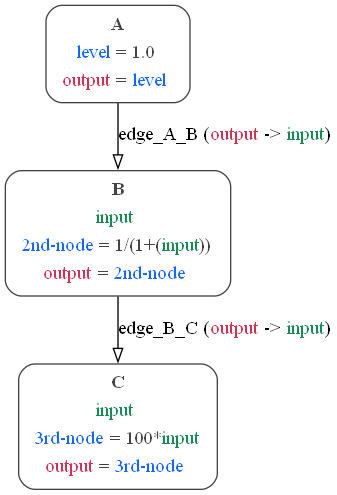

In [4]:

mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="states"
    )

from IPython.display import Image
Image(filename="states.png")


In [5]:
#Evaluating the graph once and printing out the output value
from modeci_mdf.execution_engine import EvaluableGraph

eg = EvaluableGraph(mod_graph, verbose=False)
eg.evaluate()

print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B: %s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)
print('Output of C: %s'%eg.enodes["C"].evaluable_outputs["output"].curr_value)


Init graph: state_example
Evaluating graph: state_example, root nodes: ['A'], with array format numpy
Output of A: 1
Output of B: 0.5
Output of C: 50


In [7]:
mod.to_json_file("3_connected_node.json")
mod.to_yaml_file("3_connected_node.yaml")

'3_connected_node.yaml'

## 2. Stateful Parameters in MDF
Create another MDF model using stateful parameters in the node(s) of its graph<br>Creating another node with with the intention to review a teacher and calculating its fees

In [8]:
# Create a model 
mdf_model_1 = Model(id="Teacher_fees_calculator")

# Create a graph
mdf_graph_1 = Graph(id="Teacher_fees_graph")

# Add the graph to the model
mdf_model_1.graphs.append(mdf_graph_1)

# Create the Teacher_Assesment_node 
#Here it is the parameter in which we are assigning how many months teacher will teach theiw students
Teacher_months_node_1 = Node(id="months_of_teaching")

# add a parament to the node
Teacher_months_node_1.parameters.append(Parameter(id="unit_increment", value=1.0))

# add a stateful parameter
months = Parameter(
    id="months",
    value="months + unit_increment",
)

# add the stateful parameter into the node
Teacher_months_node_1.parameters.append(months)


# Add an output port
Teacher_months_node_1.output_ports.append(OutputPort(id="output", value="months"))

mdf_graph_1.nodes.append(Teacher_months_node_1)
# Print the current structure
print(mdf_graph_1.to_yaml())

Teacher_fees_graph:
    nodes:
        months_of_teaching:
            parameters:
                unit_increment:
                    value: 1.0
                months:
                    value: months + unit_increment
            output_ports:
                output:
                    value: months



In [9]:
# Creating here fees of per months
Teacher_fees_node = Node(id="Class_Teacher_fees")
#adding an input port
Teacher_fees_node.input_ports.append(InputPort(id="input"))
# Add parameter with constant for increment as its value(it's the fees of a techer for a month)
Teacher_fees_node.parameters.append(Parameter(id="fees_per_months", value="100*input"))

# add a stateful parameter price that changes with increment(It the numbers of bacthes of students teacher teaches)
batch_of_students = Parameter(
    id="batch",
    value="batch + fees_per_months",
)

Teacher_fees_node.parameters.append(batch_of_students)


# Add an output port
Teacher_fees_node.output_ports.append(OutputPort(id="output", value="batch"))

mdf_graph_1.nodes.append(Teacher_fees_node)
# Print the current structure
print(mdf_graph_1.to_yaml())

Teacher_fees_graph:
    nodes:
        months_of_teaching:
            parameters:
                unit_increment:
                    value: 1.0
                months:
                    value: months + unit_increment
            output_ports:
                output:
                    value: months
        Class_Teacher_fees:
            input_ports:
                input: {}
            parameters:
                fees_per_months:
                    value: 100*input
                batch:
                    value: batch + fees_per_months
            output_ports:
                output:
                    value: batch



In [10]:
from modeci_mdf.utils import simple_connect

e1 = simple_connect(Teacher_months_node_1, Teacher_fees_node, mdf_graph_1)


# Print the current structure
print(mdf_graph_1.to_yaml())

Teacher_fees_graph:
    nodes:
        months_of_teaching:
            parameters:
                unit_increment:
                    value: 1.0
                months:
                    value: months + unit_increment
            output_ports:
                output:
                    value: months
        Class_Teacher_fees:
            input_ports:
                input: {}
            parameters:
                fees_per_months:
                    value: 100*input
                batch:
                    value: batch + fees_per_months
            output_ports:
                output:
                    value: batch
    edges:
        edge_months_of_teaching_Class_Teacher_fees:
            sender: months_of_teaching
            receiver: Class_Teacher_fees
            sender_port: output
            receiver_port: input



## 3.3 Generate a graph image for the model using condition

Converting MDF graph: Teacher_fees_graph to graphviz (level: 3, format: png)
    Node: months_of_teaching
    Node: Class_Teacher_fees
    Edge: edge_months_of_teaching_Class_Teacher_fees connects months_of_teaching to Class_Teacher_fees
Written graph image to: Teacher_fees_Review.png


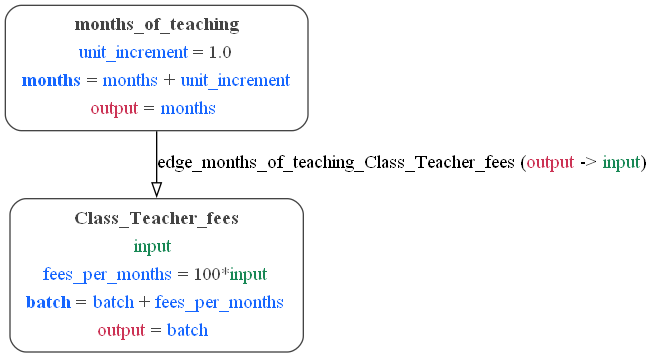

In [11]:
mdf_model_1.to_graph_image(engine="dot", 
                         output_format="png", 
                         view_on_render=False, 
                         level=3, 
                         filename_root="Teacher_fees_Review"
                        )
from IPython.display import Image
Image(filename="Teacher_fees_Review.png")

In [13]:
# Evaluating the mdf_model_graph1 once and printing out the output value
eg_1 = EvaluableGraph(mdf_graph_1, verbose=False)
dt = 1 
actual=0
#This is the number of batches teacher teaches in a month 
number_of_batch = 5
original_amount=number_of_batch*100*number_of_batch

t = 0
while t < number_of_batch:
    eg_1.evaluate(time_increment=dt)
#     print(f"runtime_{t}")
    print("\n===== Evaluating for batch = %s  ======" % (t))
    #notice that the output increments by 1 because of the stateful parameter setup on the node   
    print('Output of Number of Months: %s'%eg_1.enodes["months_of_teaching"].evaluable_outputs["output"].curr_value)
    print('Output of Fees of a Teacher: %s'%eg_1.enodes["Class_Teacher_fees"].evaluable_outputs["output"].curr_value)
    actual=eg_1.enodes["Class_Teacher_fees"].evaluable_outputs["output"].curr_value
    print("="*60,"\n")
    t += dt


Init graph: Teacher_fees_graph
Evaluating graph: Teacher_fees_graph, root nodes: ['months_of_teaching'], with array format numpy

===== Evaluating for batch = 0  ======
Output of Number of Months: 1
Output of Fees of a Teacher: 100

Evaluating graph: Teacher_fees_graph, root nodes: ['months_of_teaching'], with array format numpy

===== Evaluating for batch = 1  ======
Output of Number of Months: 2
Output of Fees of a Teacher: 300

Evaluating graph: Teacher_fees_graph, root nodes: ['months_of_teaching'], with array format numpy

===== Evaluating for batch = 2  ======
Output of Number of Months: 3
Output of Fees of a Teacher: 600

Evaluating graph: Teacher_fees_graph, root nodes: ['months_of_teaching'], with array format numpy

===== Evaluating for batch = 3  ======
Output of Number of Months: 4
Output of Fees of a Teacher: 1000

Evaluating graph: Teacher_fees_graph, root nodes: ['months_of_teaching'], with array format numpy

===== Evaluating for batch = 4  ======
Output of Number of M

## 3. Conditions in MDF
Create another MDF model using conditions to control the implementations of node(s) in its graph


## 3.1 Create the nodes 

In [14]:
# Create the model 
mdf_model_2 = Model(id="Profit_of_Company")

# Create the graph
mdf_graph_2 = Graph(id="Profit_of_Company_graph")

# Add the graph to the model
mdf_model_2.graphs.append(mdf_graph_2)

# Create a node for number of Profit of the company
Company_Profit = Node(id="Profit")

# add the months nodes and fees node into this model's graph
# this nodes were created previously for the model with stateful parameters
mdf_graph_2.nodes.append(Teacher_months_node_1)
mdf_graph_2.nodes.append(Teacher_fees_node)

# Add the profit node to this model's graph
mdf_graph_2.nodes.append(Company_Profit)
# Add a parameters
value=((original_amount-actual)/original_amount)*100
Company_Profit.parameters.append(Parameter(id="net_profit", value=value))

# Add an output port
Company_Profit.output_ports.append(OutputPort(id="output", value="net_profit"))

# Print current structure as YAML
print(mdf_graph_2.to_yaml())

Profit_of_Company_graph:
    nodes:
        months_of_teaching:
            parameters:
                unit_increment:
                    value: 1.0
                months:
                    value: months + unit_increment
            output_ports:
                output:
                    value: months
        Class_Teacher_fees:
            input_ports:
                input: {}
            parameters:
                fees_per_months:
                    value: 100*input
                batch:
                    value: batch + fees_per_months
            output_ports:
                output:
                    value: batch
        Profit:
            parameters:
                net_profit:
                    value: 40.0
            output_ports:
                output:
                    value: net_profit



## 3.2 Add Conditions

In [15]:
#This condition means that house_unit_node and house_price_node is always executed
cond_0 = Condition(type="Always")

#This condition means that B will execute when A has run 4 times
cond_1 = Condition(type="EveryNCalls", dependencies=Teacher_months_node_1.id, n=6)

In [16]:
#add the conditions to the mdf_graph_2
mdf_graph_2.conditions = ConditionSet(
    node_specific={Teacher_months_node_1.id: cond_0, Teacher_fees_node.id: cond_0, Company_Profit.id: cond_1},
)

# Print the current structure
print(mdf_graph_2.to_yaml())

Profit_of_Company_graph:
    nodes:
        months_of_teaching:
            parameters:
                unit_increment:
                    value: 1.0
                months:
                    value: months + unit_increment
            output_ports:
                output:
                    value: months
        Class_Teacher_fees:
            input_ports:
                input: {}
            parameters:
                fees_per_months:
                    value: 100*input
                batch:
                    value: batch + fees_per_months
            output_ports:
                output:
                    value: batch
        Profit:
            parameters:
                net_profit:
                    value: 40.0
            output_ports:
                output:
                    value: net_profit
    conditions:
        node_specific:
            months_of_teaching:
                type: Always
                kwargs: {}
            Class_Teacher_fees:
             

In [17]:
from modeci_mdf.utils import simple_connect

e1 = simple_connect(Teacher_months_node_1, Teacher_fees_node, mdf_graph_2)


# Print the current structure
print(mdf_graph_2.to_yaml())

Profit_of_Company_graph:
    nodes:
        months_of_teaching:
            parameters:
                unit_increment:
                    value: 1.0
                months:
                    value: months + unit_increment
            output_ports:
                output:
                    value: months
        Class_Teacher_fees:
            input_ports:
                input: {}
            parameters:
                fees_per_months:
                    value: 100*input
                batch:
                    value: batch + fees_per_months
            output_ports:
                output:
                    value: batch
        Profit:
            parameters:
                net_profit:
                    value: 40.0
            output_ports:
                output:
                    value: net_profit
    edges:
        edge_months_of_teaching_Class_Teacher_fees:
            sender: months_of_teaching
            receiver: Class_Teacher_fees
            sender_port: outp

## 3.3 Generate a graph image for the model using condition

Converting MDF graph: Profit_of_Company_graph to graphviz (level: 2, format: png)
    Node: months_of_teaching
    Node: Class_Teacher_fees
    Node: Profit
    Edge: edge_months_of_teaching_Class_Teacher_fees connects months_of_teaching to Class_Teacher_fees
Written graph image to: Company_profit.png


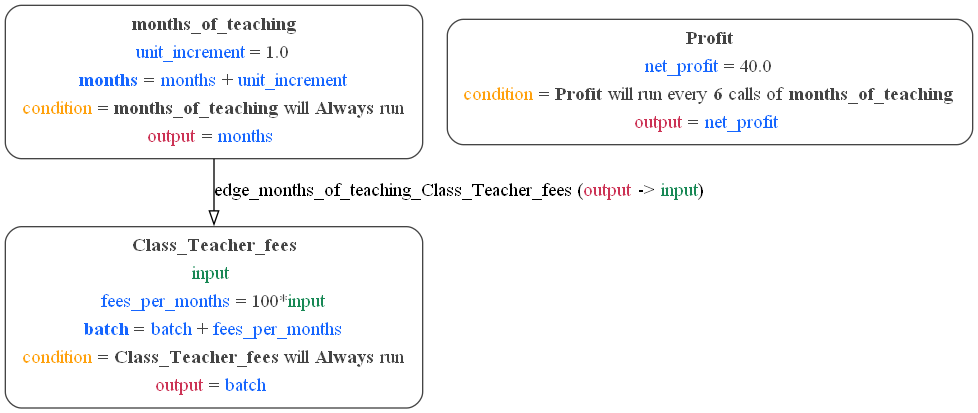

In [18]:
mdf_model_2.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=2,
        filename_root="Company_profit",
        is_horizontal=False
)

from IPython.display import Image
Image(filename="Company_profit.png")

## 3.4 Execute the Graph

In [20]:
eg_2 = EvaluableGraph(mdf_graph_2, verbose=False)

eg_2.evaluate()

# Months node will execute 5 times before Profit node executes once
print(f'Number of Months: {eg_2.enodes["months_of_teaching"].evaluable_outputs["output"].curr_value-1}') 

# Fees node will execute everytime Months node executes
print(f'Fees for 5 batches for 5 months a: {eg_2.enodes["Class_Teacher_fees"].evaluable_outputs["output"].curr_value}')

# Profit node will execute once for 5 runs of months and fees node
print(f'Profit of a Company: {eg_2.enodes["Profit"].evaluable_outputs["output"].curr_value}')



Init graph: Profit_of_Company_graph
Evaluating graph: Profit_of_Company_graph, root nodes: ['months_of_teaching', 'Profit'], with array format numpy
Number of Months: 5
Fees for 5 batches for 5 months a: 1500
Profit of a Company: 40
